In [1]:
# Mental Health Age Prediction Analysis
# Using regression models to predict age from mental health survey responses

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

Original shape: (1259, 27)
Columns: ['timestamp', 'age', 'gender', 'country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments']

Age info:
Range: 18.0 to 72.0
Missing ages: 0
After age cleaning: 1259 rows

Using 22 features: ['gender', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'tech_company', 'benefits', 'seek_help', 'mental_health_consequence', 'coworkers', 'supervisor', 'self_employed', 'remote_work', 'care_options', 'wellness_program', 'anonymity', 'leave', 'phys_health_consequence', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']
Final features (22): ['gender', 'family_history',

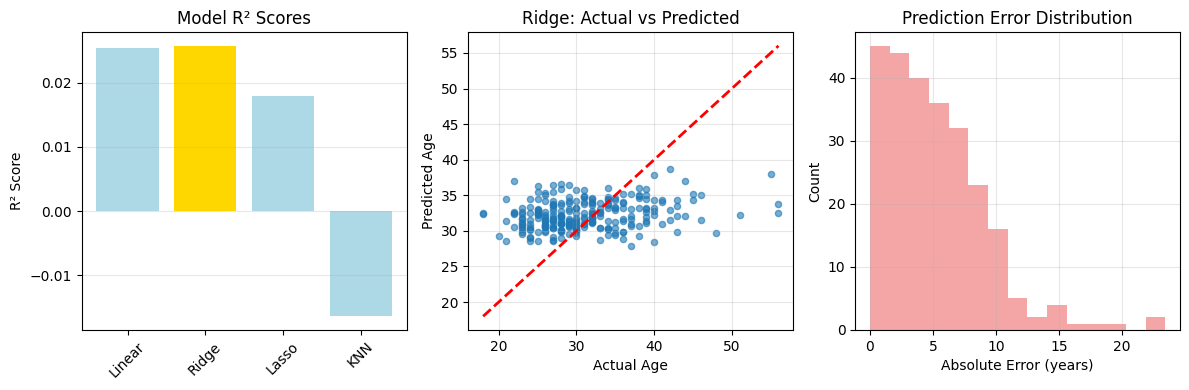


🎯 QUICK ANALYSIS:
• Dataset: 252 test samples
• Features used: 22
• Best R²: 0.0258
• Average error: 5.2 years
⚠️  R² is low but reasonable for this type of data

💡 To improve further:
• Try feature engineering (combine features)
• Add polynomial features
• Use ensemble methods
• Check for data quality issues


In [1]:
# Mental Health Age Prediction - Simple & Robust Version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ## 1. Load Data
df = pd.read_csv('mental_health_cleaned.csv')
print(f"Original shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# ## 2. Quick Data Check
print(f"\nAge info:")
print(f"Range: {df['age'].min()} to {df['age'].max()}")
print(f"Missing ages: {df['age'].isnull().sum()}")

# Clean age data
df = df.dropna(subset=['age'])
df = df[(df['age'] >= 15) & (df['age'] <= 80)]  # Remove unrealistic ages
print(f"After age cleaning: {df.shape[0]} rows")

# ## 3. Select Features (Conservative Approach)
# Start with basic features that definitely exist
basic_features = ['gender', 'family_history', 'treatment', 'work_interfere', 
                 'no_employees', 'tech_company', 'benefits', 'seek_help',
                 'mental_health_consequence', 'coworkers', 'supervisor']

# Add extra features if they exist (these might help improve R²)
extra_features = ['self_employed', 'remote_work', 'care_options', 'wellness_program',
                 'anonymity', 'leave', 'phys_health_consequence',
                 'mental_health_interview', 'phys_health_interview', 
                 'mental_vs_physical', 'obs_consequence']

# Check which features actually exist
features = []
for f in basic_features + extra_features:
    if f in df.columns and df[f].notna().sum() > 100:  # Must have at least 100 valid values
        features.append(f)

print(f"\nUsing {len(features)} features: {features}")

# ## 4. Simple Data Preprocessing
data = df[features + ['age']].copy()

# Handle missing values - simple approach
for col in features:
    if data[col].dtype == 'object':
        # Text: fill with 'Unknown'
        data[col] = data[col].fillna('Unknown')
    else:
        # Numbers: fill with median
        data[col] = data[col].fillna(data[col].median())

# Convert text to numbers
encoders = {}
for col in features:
    if data[col].dtype == 'object':
        # Only encode if reasonable number of categories
        if data[col].nunique() <= 20:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col].astype(str))
            encoders[col] = le
        else:
            print(f"Skipping {col} - too many categories ({data[col].nunique()})")
            features.remove(col)

# Final check - remove any columns that are still problematic
final_features = []
for col in features:
    if col in data.columns and data[col].dtype in ['int64', 'float64', 'int32', 'float32']:
        if not data[col].isnull().any() and np.isfinite(data[col]).all():
            final_features.append(col)

features = final_features
print(f"Final features ({len(features)}): {features}")

# ## 5. Prepare Training Data
X = data[features].astype(float)
y = data['age'].astype(float)

print(f"\nFinal data shape: X={X.shape}, y={y.shape}")
print(f"Age range: {y.min():.1f} to {y.max():.1f}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ## 6. Train Models (Safe Approach)
models = {}
results = {}

print("\n" + "="*50)
print("TRAINING MODELS")
print("="*50)

# Model 1: Linear Regression
print("\n1. Linear Regression")
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

results['Linear'] = {
    'mae': mean_absolute_error(y_test, lr_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, lr_pred)),
    'r2': r2_score(y_test, lr_pred),
    'predictions': lr_pred
}
print(f"R² = {results['Linear']['r2']:.4f}")

# Model 2: Ridge Regression
print("\n2. Ridge Regression")
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

results['Ridge'] = {
    'mae': mean_absolute_error(y_test, ridge_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, ridge_pred)),
    'r2': r2_score(y_test, ridge_pred),
    'predictions': ridge_pred
}
print(f"R² = {results['Ridge']['r2']:.4f}")

# Model 3: Lasso Regression
print("\n3. Lasso Regression")
lasso = Lasso(alpha=0.1, max_iter=2000)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

results['Lasso'] = {
    'mae': mean_absolute_error(y_test, lasso_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, lasso_pred)),
    'r2': r2_score(y_test, lasso_pred),
    'predictions': lasso_pred
}
print(f"R² = {results['Lasso']['r2']:.4f}")

# Model 4: KNN (Simple version)
print("\n4. K-Nearest Neighbors")
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

results['KNN'] = {
    'mae': mean_absolute_error(y_test, knn_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, knn_pred)),
    'r2': r2_score(y_test, knn_pred),
    'predictions': knn_pred
}
print(f"R² = {results['KNN']['r2']:.4f}")

# ## 7. Results Comparison
print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)
print(f"{'Model':<12} {'R²':<8} {'MAE':<8} {'RMSE':<8}")
print("-" * 40)

best_model = max(results.keys(), key=lambda x: results[x]['r2'])

for name, metrics in results.items():
    marker = "🏆" if name == best_model else "  "
    print(f"{marker} {name:<10} {metrics['r2']:<8.3f} {metrics['mae']:<8.1f} {metrics['rmse']:<8.1f}")

print(f"\nBest model: {best_model}")
print(f"Best R²: {results[best_model]['r2']:.4f}")

# ## 8. Simple Visualization
plt.figure(figsize=(12, 4))

# Plot 1: R² comparison
plt.subplot(1, 3, 1)
names = list(results.keys())
r2_scores = [results[name]['r2'] for name in names]
colors = ['gold' if name == best_model else 'lightblue' for name in names]
plt.bar(names, r2_scores, color=colors)
plt.title('Model R² Scores')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Plot 2: Best model predictions
plt.subplot(1, 3, 2)
best_pred = results[best_model]['predictions']
plt.scatter(y_test, best_pred, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title(f'{best_model}: Actual vs Predicted')
plt.grid(True, alpha=0.3)

# Plot 3: Error distribution
plt.subplot(1, 3, 3)
errors = abs(y_test - best_pred)
plt.hist(errors, bins=15, alpha=0.7, color='lightcoral')
plt.xlabel('Absolute Error (years)')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ## 9. Quick Analysis
print(f"\n🎯 QUICK ANALYSIS:")
print(f"• Dataset: {len(y_test)} test samples")
print(f"• Features used: {len(features)}")
print(f"• Best R²: {results[best_model]['r2']:.4f}")
print(f"• Average error: {results[best_model]['mae']:.1f} years")

if results[best_model]['r2'] > 0.05:
    print("✅ R² > 0.05 - Good job!")
elif results[best_model]['r2'] > 0.02:
    print("⚠️  R² is low but reasonable for this type of data")
else:
    print("❌ R² is very low - age might not be predictable from these features")

print(f"\n💡 To improve further:")
print("• Try feature engineering (combine features)")
print("• Add polynomial features") 
print("• Use ensemble methods")
print("• Check for data quality issues")